In [1]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, isnan, when, count, trim, desc, sum, asc
from pyspark.sql.functions import countDistinct, explode, split, concat_ws, collect_list
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType as R, StructField as Fld, DoubleType as Dbl, StringType as Str, IntegerType as Int, DateType as Date

import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [2]:
spark = SparkSession \
    .builder \
    .appName("antioxidants analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
dSchema = R([
            Fld("Product",Str()),
            Fld("origin",Str()),
            Fld("Procured_in",Str()),
            Fld("antioxidant_content_mmol_100g", Dbl())
            ])

In [4]:
#read in tables
dffruits = spark.read.csv("dbfs:/FileStore/tables/Fruit.csv", header=True, schema=dSchema)
dfvegetables = spark.read.csv("dbfs:/FileStore/tables/Vegetables.csv", header = True, schema=dSchema)
dfnuts = spark.read.csv("dbfs:/FileStore/tables/Nuts_and_seeds.csv", header = True, schema=dSchema)

In [5]:
dffruits = dffruits.withColumn('category', lit('Fruit'))
dffruits.show(5, truncate = True)
dffruits.count()

+--------------------+--------------------+-----------+-----------------------------+--------+
 Product| origin|Procured_in|antioxidant_content_mmol_100g|category|
+--------------------+--------------------+-----------+-----------------------------+--------+
Apples, Composite...| null| USA| 0.31| Fruit|
 Apples, dried| Eldorado, Germany| Norway| 1.86| Fruit|
 Apples, dried|Fruit Zone, Horiz...| Norway| 3.49| Fruit|
Apples, dried (Ta...| Australia|New Zealand| 6.07| Fruit|
 Apples, Fuji| null| USA| 0.22| Fruit|
+--------------------+--------------------+-----------+-----------------------------+--------+
only showing top 5 rows

Out[59]: 398

In [6]:
dfvegetables = dfvegetables.withColumn('category', lit('Vegetables'))
dfvegetables.show(5, truncate = True)
dfvegetables.count()

+--------------------+--------------+-----------+-----------------------------+----------+
 Product| origin|Procured_in|antioxidant_content_mmol_100g| category|
+--------------------+--------------+-----------+-----------------------------+----------+
 Alfa sprouts|Natural Spirer| Norway| 0.14|Vegetables|
 Artichoke| Italy| Norway| 0.69|Vegetables|
 Artichoke, boiled| Other Brand| USA| 3.89|Vegetables|
 Artichoke, boiled| Ocean Mist| USA| 4.54|Vegetables|
Artichoke, brine ...| Delallo| USA| 3.36|Vegetables|
+--------------------+--------------+-----------+-----------------------------+----------+
only showing top 5 rows

Out[60]: 303

In [7]:
dfnuts = dfnuts.withColumn('category', lit('Nuts and Seeds'))
dfnuts.show(5, truncate = True)
dfnuts.count()

+--------------------+-----------------+-----------+-----------------------------+--------------+
 Product| origin|Procured_in|antioxidant_content_mmol_100g| category|
+--------------------+-----------------+-----------+-----------------------------+--------------+
Almonds, with pel...| Kjøkkensjefens| Norway| 0.23|Nuts and Seeds|
Almonds, with pel...| Eldorado| Norway| 0.37|Nuts and Seeds|
Almonds, with pel...| Coop Chef's| Norway| 0.28|Nuts and Seeds|
Almonds, with pel...| null| USA| 0.53|Nuts and Seeds|
Almonds, with pel...|Blue Diamond, USA| Norway| 0.26|Nuts and Seeds|
+--------------------+-----------------+-----------+-----------------------------+--------------+
only showing top 5 rows

Out[61]: 90

In [8]:
#union 3 tables
All = dffruits.unionAll(dfvegetables).unionAll(dfnuts)
All.show(5, truncate = True)
All.count()

+--------------------+--------------------+-----------+-----------------------------+--------+
 Product| origin|Procured_in|antioxidant_content_mmol_100g|category|
+--------------------+--------------------+-----------+-----------------------------+--------+
Apples, Composite...| null| USA| 0.31| Fruit|
 Apples, dried| Eldorado, Germany| Norway| 1.86| Fruit|
 Apples, dried|Fruit Zone, Horiz...| Norway| 3.49| Fruit|
Apples, dried (Ta...| Australia|New Zealand| 6.07| Fruit|
 Apples, Fuji| null| USA| 0.22| Fruit|
+--------------------+--------------------+-----------+-----------------------------+--------+
only showing top 5 rows

Out[120]: 791

In [9]:
#simplify product name
All = All.withColumn('productArray', split(col("Product"),",")).drop('Product')
All = All.withColumn('product_name', col('productArray')[0]).drop('productArray')
All.show(5)

+--------------------+-----------+-----------------------------+--------+------------+
 origin|Procured_in|antioxidant_content_mmol_100g|category|product_name|
+--------------------+-----------+-----------------------------+--------+------------+
 null| USA| 0.31| Fruit| Apples|
 Eldorado, Germany| Norway| 1.86| Fruit| Apples|
Fruit Zone, Horiz...| Norway| 3.49| Fruit| Apples|
 Australia|New Zealand| 6.07| Fruit| Apples|
 null| USA| 0.22| Fruit| Apples|
+--------------------+-----------+-----------------------------+--------+------------+
only showing top 5 rows

In [10]:
anti_category = All.groupBy("category").agg(F.avg("antioxidant_content_mmol_100g").alias('avg_antioxidant')).orderBy(desc('avg_antioxidant'))
anti_category.show(truncate = False)

+--------------+------------------+
category |avg_antioxidant |
+--------------+------------------+
Nuts and Seeds|4.574333333333334 |
Fruit |3.8280352644836255|
Vegetables |0.8024752475247526|
+--------------+------------------+

In [11]:
anti_product = All.groupBy("product_name").agg(F.avg("antioxidant_content_mmol_100g").alias('avg_antioxidant')).orderBy(desc('avg_antioxidant'))
anti_product.show(5, truncate = False)

+-----------------------------------+---------------+
product_name |avg_antioxidant|
+-----------------------------------+---------------+
Amla berries |261.53 |
Dog Roseshell |75.84 |
Leaves from the African Baobab tree|48.07 |
"Blackberries |37.08 |
Dog Rose |33.6075 |
+-----------------------------------+---------------+
only showing top 5 rows

In [12]:
#using Spark Sql to analyze the data
All.createOrReplaceTempView("All")     

In [13]:
#top 20 fruits high in antioxidants
spark.sql("""select distinct
             product_name,
             avg(antioxidant_content_mmol_100g) as avg_antioxidants
             from All
             where category = 'Fruit' and Procured_in = "USA"
             group by product_name
             order by avg_antioxidants desc
             limit 10
""").show(truncate = False)

+--------------------------------+------------------+
product_name |avg_antioxidants |
+--------------------------------+------------------+
Goji Berries |4.31 |
Sweet cherries |4.05 |
Blackberries |3.9899999999999998|
Cranberries |2.465 |
Raspberries |2.33 |
Prunes |2.205 |
Blueberries |2.166 |
Strawberries |2.16 |
Cherries |1.5716666666666665|
Cranberry craisins cherry flavor|1.47 |
+--------------------------------+------------------+

In [14]:
#top 20 vegetables high in antioxidants
spark.sql("""select distinct
             product_name,
             avg(antioxidant_content_mmol_100g) as avg_antioxidants
             from All
             where category = 'Vegetables' and Procured_in = "USA"
             group by product_name
             order by avg_antioxidants desc
             limit 10
""").show(truncate = False)

+-------------+-------------------+
product_name |avg_antioxidants |
+-------------+-------------------+
Artichoke |4.16 |
Spinach |1.1353846153846152 |
Pepper |1.0075 |
Cabbage |0.875 |
Broccoli raab|0.81 |
Tomato juice |0.65 |
Broccoli |0.625 |
Asparagus |0.5549999999999999 |
Avocado |0.41 |
Sweet potatoe|0.39999999999999997|
+-------------+-------------------+

In [15]:
#top 20 nuts high in antioxidants
spark.sql("""select distinct
             product_name,
             avg(antioxidant_content_mmol_100g) as avg_antioxidants
             from All
             where category = 'Nuts and Seeds' and Procured_in = "USA"
             group by product_name
             order by avg_antioxidants desc
             limit 10
""").show(truncate = False)

+-------------+----------------+
product_name |avg_antioxidants|
+-------------+----------------+
Walnuts |13.13 |
Pecans |9.67 |
Pistachios |1.43 |
Flaxseed |0.965 |
Hazelnuts |0.94 |
Pine nuts |0.71 |
Cashews |0.66 |
Peanut butter|0.5725 |
Almonds |0.53 |
Brazil nuts |0.47 |
+-------------+----------------+

In [16]:
#import txt file with 25 selected food and their prices
dfprices = spark.read.option("header", "true") \
    .option("delimiter", "|") \
    .option("inferSchema", "true") \
    .csv("dbfs:/FileStore/tables/30_products_w_prices-1.txt")

dfprices.show(10, truncate=False)

+-----------------+-------------------------+---------------+
product |avg_antioxidant_mmol_100g|price_per_pound|
+-----------------+-------------------------+---------------+
Goji Berries |4.31 |13.99 |
Sweet cherries |4.05 |5.05 |
Blackberries |3.99 |2.0 |
Cranberries |2.47 |10.99 |
Raspberries |2.33 |8.4 |
Prunes |2.21 |4.99 |
Blueberries |2.17 |2.0 |
Strawberries |2.16 |2.4 |
Cherries |1.57 |2.25 |
Plums |1.33 |1.99 |
+-----------------+-------------------------+---------------+
only showing top 10 rows

In [17]:
dfprices.columns

Out[136]: ['product', 'avg_antioxidant_mmol_100g', 'price_per_pound']

In [18]:
#using Spark Sql to analyze the data
dfprices.createOrReplaceTempView("dfprices")     

In [19]:
food_antioxidant = spark.sql("""select distinct
             product,
             avg_antioxidant_mmol_100g as avg_antioxidants,
             price_per_pound as price_per_pound,
             avg_antioxidant_mmol_100g/0.22/price_per_pound as mmol_per_dollar
             from dfprices
             order by 4 desc
""")
food_antioxidant.show(truncate = False)

+-----------------+----------------+---------------+------------------+
product |avg_antioxidants|price_per_pound|mmol_per_dollar |
+-----------------+----------------+---------------+------------------+
Walnuts |13.13 |2.1 |28.41991341991342 |
Blackberries |3.99 |2.0 |9.068181818181818 |
Artichoke |4.16 |2.36 |8.012326656394453 |
Pecans |9.67 |6.99 |6.2882039276889055|
Spinach |1.14 |1.0 |5.181818181818182 |
Blueberries |2.17 |2.0 |4.931818181818182 |
Cabbage |0.88 |0.91 |4.395604395604395 |
Strawberries |2.16 |2.4 |4.090909090909091 |
Sweet cherries |4.05 |5.05 |3.645364536453645 |
Cherries |1.57 |2.25 |3.1717171717171717|
Pepper |1.01 |1.49 |3.0811470408785846|
Plums |1.33 |1.99 |3.0379168570123345|
Kiwi |1.33 |2.18 |2.773144286905755 |
Broccoli raab |0.81 |1.8 |2.0454545454545454|
Prunes |2.21 |4.99 |2.0131171433776642|
Peanut butter |0.57 |1.3 |1.993006993006993 |
Sweet potatoes |0.4 |1.05 |1.7316017316017316|
Broccoli |0.63 |1.8 |1.5909090909090908|
Tomato juice |0.65 |1.98 |1.4921946740128558|
Goji Berries |4.31 |13.99 |1.4003508999935017|
+-----------------+----------------+---------------+------------------+
only showing top 20 rows

In [20]:
food_antioxidant_pd = food_antioxidant.toPandas()

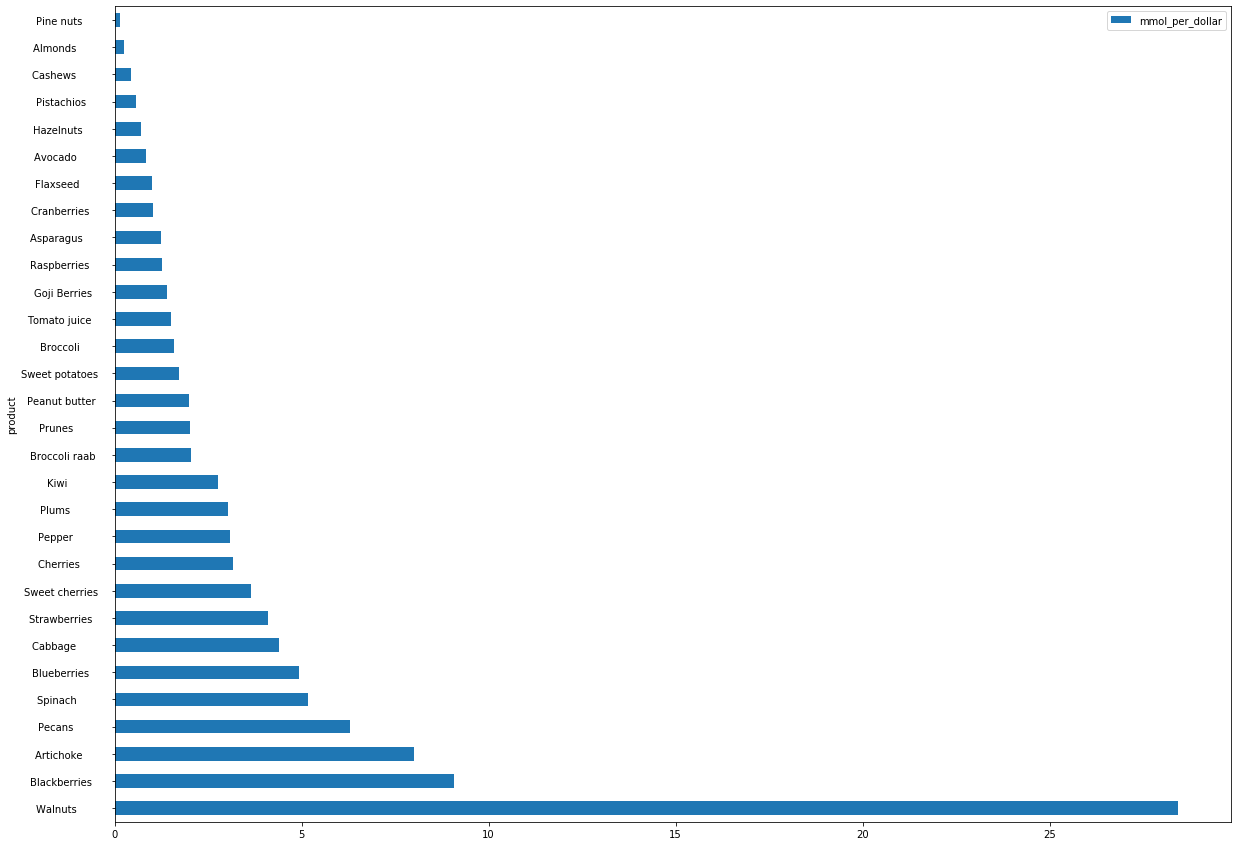

In [21]:
food_antioxidant_pd.plot.barh(
  x="product",
  y="mmol_per_dollar",
  figsize=(20, 15),
)